<a href="https://colab.research.google.com/github/madanmohan-venkatesan/notebooks/blob/main/2011_03567.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from scipy.special import gamma
from scipy.optimize import minimize
from matplotlib import pyplot as plt
import seaborn as sns

# 2. A sequential multinomial test


In [2]:
#CONSTANTS
CLASSES=2
VECTOR_SIZE=100

In [3]:
theta_null=np.array([1/CLASSES]*CLASSES) #Simplex
rng = np.random.default_rng()
vectors_null=rng.multinomial(1,theta_null,size=VECTOR_SIZE)

In [4]:
K=100
alpha_dirichlet=K*theta_null
rng = np.random.default_rng()
theta_alt=rng.dirichlet(alpha_dirichlet)
vectors_alt=rng.multinomial(1,theta_alt,size=VECTOR_SIZE)

In [5]:
s_n_null=np.sum(vectors_null,axis=0)
s_n_alt=np.sum(vectors_alt,axis=0)

In [6]:
def beta(v):

  numerator=np.prod(gamma(v))
  denominator=gamma(np.sum(v))
  if numerator.any() is np.nan or denominator.any() is np.nan:
    return [np.inf,np.inf]
  else:
    return numerator/denominator


In [7]:
def bf_10(dirichlet_alpha,theta,counts):
  term1_numerator=beta(dirichlet_alpha+counts)
  term1_denominator=beta(dirichlet_alpha)
  term1=term1_numerator/term1_denominator

  term2=1/(theta**counts)
  if term1.any() is np.inf or term2.any() is np.inf:
    return [np.inf,np.inf]
  else:
    return term1*term2


In [8]:
bf_10(alpha_dirichlet,theta_null,s_n_null)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
<ipython-input-6-2a308695fdf7>:8: RuntimeWarning: invalid value encountered in scalar divide
  return numerator/denominator


array([nan, nan])

In [9]:
bf_10(alpha_dirichlet,theta_null,s_n_alt)

<ipython-input-6-2a308695fdf7>:8: RuntimeWarning: invalid value encountered in scalar divide
  return numerator/denominator


array([nan, nan])

For above bf_10, if theta_0 not equal theta then values will go to infinity (reject null hypothesis)
otherwise value is zero(accept null hypothesis)

Hyper paramters to play around with are K and vector size



In [10]:
theta_null_arr=[]
theta_alt_arr=[]
dirichlet_alpha_arr=[]
vetors_null_arr=[]
vectors_alt_arr=[]
for i in range(10):
  if i==0:
    K=10
  else:
    K=K#+(0.5*K)
  #generate null vectors
  theta_null=np.array([1/CLASSES]*CLASSES) #Simplex
  rng = np.random.default_rng()
  vectors_null=rng.multinomial(1,theta_null,size=VECTOR_SIZE)
  #generate alt vectors

  alpha_dirichlet=K*theta_null
  rng = np.random.default_rng()
  theta_alt=rng.dirichlet(alpha_dirichlet)
  vectors_alt=rng.multinomial(1,theta_alt,size=VECTOR_SIZE)

  theta_null_arr.append(theta_null)
  theta_alt_arr.append(theta_alt)
  dirichlet_alpha_arr.append(alpha_dirichlet)
  vetors_null_arr.append(vectors_null)
  vectors_alt_arr.append(vectors_alt)

In [11]:
on_theta_hist_arr=[]
for i in range(len(theta_null_arr)):
  on_theta_prev = None
  if i==0:
    on_theta_prev = np.array([1,1])
    on_theta_hist_arr.append(on_theta_prev)

  else:
    s_n_null=np.sum(vetors_null_arr[i],axis=0)
    s_n_alt=np.sum(vectors_alt_arr[i],axis=0)
    term1_numerator=beta(dirichlet_alpha_arr[i]+s_n_alt)
    term1_denominator=beta(dirichlet_alpha_arr[i])
    term1=term1_numerator/term1_denominator

    term2=1/(theta_null_arr[i]**s_n_alt)

    on_theta_hist_arr.append(on_theta_hist_arr[i-1]*term1*term2)

# Optimization problem for theta

In [12]:
def objective(theta, i,maximize=True):
    """
    Objective function to maximize theta_i.

    Parameters:
    - theta (array): Probability vector (simplex).
    - i (int): Index of the element to maximize.

    Returns:
    - float: Negative of theta[i] to convert minimization to maximization.
    """
    if maximize:
        return -theta[i]
    else:
      return theta[i]

def constraint_sum(theta):
    """
    Constraint ensuring that the sum of theta is 1.

    Parameters:
    - theta (array): Probability vector (simplex).

    Returns:
    - float: Sum of theta - 1 (should be 0).
    """
    return np.sum(theta) - 1

def constraint_log_likelihood(theta, Sn, c):
    """
    Log-likelihood constraint.

    Parameters:
    - theta (array): Probability vector (simplex).
    - Sn (array): Observed count vector S_{n,i}.
    - c (float): Constant c + log u.

    Returns:
    - float: Left-hand side of the constraint.
    """
    return np.sum(Sn * np.log(theta)) - c

# Real simulation

In [21]:
#CONSTANTS
CLASSES=2
VECTOR_SIZE=100000

theta_null=np.array([1/CLASSES]*CLASSES) #Simplex
rng = np.random.default_rng()
vectors_null=rng.multinomial(1,theta_null,size=VECTOR_SIZE)

K=5
alpha_dirichlet=K*theta_null
rng = np.random.default_rng()
theta_alt=rng.dirichlet(alpha_dirichlet)
vectors_alt=rng.multinomial(1,theta_alt,size=VECTOR_SIZE)


on_theta_hist_arr=[]
theta_alt_1max_arr=[]
theta_alt_1min_arr=[]

theta_alt_0max_arr=[]
theta_alt_0min_arr=[]

for i in range(0,VECTOR_SIZE,int(VECTOR_SIZE/1000)):
  on_theta_prev = None
  vectors_null_i=[]
  vectors_alt_i=[]
  if i==0:
    on_theta_prev = np.array([1,1])
    vectors_null_i=vectors_null[i]
    vectors_alt_i=vectors_alt[i]
    on_theta_hist_arr.append(on_theta_prev)
  else:
    vectors_null_i=vectors_null[:i]
    vectors_alt_i=vectors_alt[:i]



  s_n_null=np.sum(vectors_null_i,axis=0)
  s_n_alt=np.sum(vectors_alt_i,axis=0)


  term1_numerator=beta(alpha_dirichlet+s_n_alt)
  term1_denominator=beta(alpha_dirichlet)
  term1=term1_numerator/term1_denominator

  term2=1/(theta_null**s_n_alt)
  on_theta_hist_arr.append(on_theta_hist_arr[-1]*term1*term2)

  c = np.log(beta(alpha_dirichlet+s_n_alt)) - np.log(beta(alpha_dirichlet))  # Example constant for log Beta terms
  u = 0.05  # Example confidence level
  c += np.log(u)

  # Initial guess for theta (uniform distribution)
  initial_theta = np.full(len(theta_alt), 1 / len(theta_alt))

  # Constraints
  constraints = [
      {'type': 'eq', 'fun': constraint_sum},
      {'type': 'ineq', 'fun': constraint_log_likelihood, 'args': (s_n_alt, c)}
  ]

  # Bounds to ensure theta remains within [0, 1]
  bounds = [(0, 1) for _ in range(len(theta_alt))]

  # Solve the optimization problem
  result0 = minimize(objective, initial_theta, args=(0,True), bounds=bounds, constraints=constraints, method='SLSQP')
  result1 = minimize(objective, initial_theta, args=(1,True), bounds=bounds, constraints=constraints, method='SLSQP')

  # Display the result
  if result0.success:
      theta_alt_0max_arr.append(result0.x[0])
  else:
      print("Optimization failed:", result0.message)

  if result1.success:
      theta_alt_1max_arr.append(result1.x[0])
  else:
      print("Optimization failed:", result1.message)




  # Solve the optimization problem

  result0 = minimize(objective, initial_theta, args=(0,False), bounds=bounds, constraints=constraints, method='SLSQP')
  result1 = minimize(objective, initial_theta, args=(1,False), bounds=bounds, constraints=constraints, method='SLSQP')

  # Display the result
  if result0.success:
      theta_alt_0min_arr.append(result0.x[0])
  else:
      print("Optimization failed:", result0.message)

  if result1.success:
      theta_alt_1min_arr.append(result1.x[0])
  else:
      print("Optimization failed:", result1.message)

<ipython-input-6-2a308695fdf7>:8: RuntimeWarning: invalid value encountered in scalar divide
  return numerator/denominator
<ipython-input-21-ad29e2139d51>:46: RuntimeWarning: overflow encountered in divide
  term2=1/(theta_null**s_n_alt)
<ipython-input-21-ad29e2139d51>:46: RuntimeWarning: divide by zero encountered in divide
  term2=1/(theta_null**s_n_alt)


Optimization failed: Inequality constraints incompatible
Optimization failed: Inequality constraints incompatible
Optimization failed: Inequality constraints incompatible
Optimization failed: Inequality constraints incompatible
Optimization failed: Inequality constraints incompatible
Optimization failed: Inequality constraints incompatible
Optimization failed: Inequality constraints incompatible
Optimization failed: Inequality constraints incompatible
Optimization failed: Inequality constraints incompatible
Optimization failed: Inequality constraints incompatible
Optimization failed: Inequality constraints incompatible
Optimization failed: Inequality constraints incompatible
Optimization failed: Inequality constraints incompatible
Optimization failed: Inequality constraints incompatible
Optimization failed: Inequality constraints incompatible
Optimization failed: Inequality constraints incompatible
Optimization failed: Inequality constraints incompatible
Optimization failed: Inequality

In [22]:
theta_alt

array([0.78546575, 0.21453425])

In [23]:
on_theta_hist_arr
p_value_arr=1/np.array(on_theta_hist_arr)
p_clip=[]
for i in range(len(p_value_arr)):
  if i==0:
    p_clip.append(np.array([1,1]))
  else:
    p_clip.append(np.clip(p_value_arr[i],p_value_arr[i],p_clip[i-1]))
p_clip

[array([1, 1]),
 array([1., 1.]),
 array([8.29590524e-12, 1.00000000e+00]),
 array([nan, nan]),
 array([nan, nan]),
 array([nan, nan]),
 array([nan, nan]),
 array([nan, nan]),
 array([nan, nan]),
 array([nan, nan]),
 array([nan, nan]),
 array([nan, nan]),
 array([nan, nan]),
 array([nan, nan]),
 array([nan, nan]),
 array([nan, nan]),
 array([nan, nan]),
 array([nan, nan]),
 array([nan, nan]),
 array([nan, nan]),
 array([nan, nan]),
 array([nan, nan]),
 array([nan, nan]),
 array([nan, nan]),
 array([nan, nan]),
 array([nan, nan]),
 array([nan, nan]),
 array([nan, nan]),
 array([nan, nan]),
 array([nan, nan]),
 array([nan, nan]),
 array([nan, nan]),
 array([nan, nan]),
 array([nan, nan]),
 array([nan, nan]),
 array([nan, nan]),
 array([nan, nan]),
 array([nan, nan]),
 array([nan, nan]),
 array([nan, nan]),
 array([nan, nan]),
 array([nan, nan]),
 array([nan, nan]),
 array([nan, nan]),
 array([nan, nan]),
 array([nan, nan]),
 array([nan, nan]),
 array([nan, nan]),
 array([nan, nan]),
 arr

In [15]:
print(len(on_theta_hist_arr))
print(len(theta_alt_1max_arr))
print(len(theta_alt_1min_arr))
print(len(theta_alt_0max_arr))
print(len(theta_alt_0min_arr))




1001
171
171
171
171


ValueError: operands could not be broadcast together with shapes (1000,) (171,) 

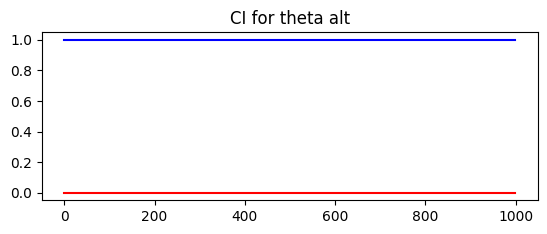

In [16]:
plt.subplot(2,1,1)
plt.title("CI for theta alt")
lenght=len(on_theta_hist_arr)-1
plt.plot(range(lenght),[theta_alt[0]]*lenght,color='r',label="theta_alt for theta_1")
plt.plot(range(lenght),[theta_alt[1]]*lenght,color='b',label="theta_alt for theta_2")

plt.fill_between(range(lenght),
                 np.array(theta_alt_0min_arr),
                 np.array(theta_alt_0max_arr), color='r',
                 alpha=0.2, label="CI for theta_1")  # alpha controls transparency


plt.fill_between(range(lenght),
                 np.array(theta_alt_1min_arr),
                 np.array(theta_alt_1max_arr), color='b',
                 alpha=0.2, label="CI for theta_2")  # alpha controls transparency


# plt.plot(range(len(theta_alt_arr)),np.array(theta_alt_min_arr)[:,0],label="theta_alt min for theta_1")
# plt.plot(range(len(theta_alt_arr)),np.array(theta_alt_max_arr)[:,0],label="theta_alt max for theta_1")
# plt.plot(range(len(theta_alt_arr)),np.array(theta_alt_min_arr)[:,1],label="theta_alt min for theta_2")
# plt.plot(range(len(theta_alt_arr)),np.array(theta_alt_max_arr)[:,1],label="theta_alt max for theta_2")

plt.legend()
plt.subplot(3,1,2)
plt.title("Bayes factor for M1|M0")
plt.plot(range(lenght),np.array(p_clip)[:-1,0],color='r',label="Bayes factor for theta 1")
plt.plot(range(lenght),[0.05]*lenght,'--',color='b',label="0.05")
plt.legend()
plt.plot()


plt.subplot(3,1,3)
plt.title("Bayes factor for M1|M0")
plt.plot(range(lenght),np.array(p_clip)[:-1,1],color='r',label="Bayes factor for theta 2")
plt.plot(range(lenght),[0.05]*lenght,'--',color='b',label="0.05")
plt.legend()
plt.plot()

In [ ]:
np.round(theta_alt_0min_arr,3)

In [ ]:
np.round(theta_alt_1min_arr,3)

In [ ]:
np.round(theta_alt_1max_arr,3)

In [ ]:
np.round(theta_alt_0max_arr,3)

In [ ]:
1/np.array(on_theta_hist_arr) < (1/0.05)